In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from IPython.display import Audio
import scipy
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
from scipy.io.wavfile import write
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from scipy.fftpack import dct
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
import sounddevice as sd
import wavio as wv
from datetime import datetime
import threading
import time
from time import sleep
from statistics import stdev

# Data Preparation

## Data Loading

In [5]:
# Real Cough Timestamps of the Data

def get_real_timestamps(audio_timestamp):

    timestamp = []
    f = open(audio_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append(float(line.split("\t")[0]))
    
    return timestamp

In [6]:
# Loading all data
def load_data(audio_file_path, timestamp_file_path, label, sr=48000):
    
    audio_files = [file for file in os.listdir(audio_file_path) if file.endswith('.wav')]
    timestamp_files = [file for file in os.listdir(timestamp_file_path) if file.endswith('.txt')]
    
    
    audios = []
    timestamps = []
    labels = []
    
    for file in audio_files:
    
        file_name = file.split(".wav")[0]    
        timestamp_files = [file[0:19] for file in timestamp_files]    

        
        # Finding correspoding timestamp file
        index = timestamp_files.index(file_name)
        timestamp_data = timestamp_files[index]

        file_path = audio_file_path + file
        timestamp_path = timestamp_file_path + timestamp_data + '-label.txt'

        # Adding timestamps to the list
        real_timestamps = get_real_timestamps(timestamp_path)    

        # Loading audio_file
        data, sample_rate = librosa.load(file_path, sr=sr, mono=True)
        data = librosa.resample(data, orig_sr=sample_rate, target_sr=48000)
        
        audios.append(data)
        timestamps.append(real_timestamps)
        labels.append(label)

    
    return audios, timestamps, labels

In [7]:
audio_data = {'audio': [], 'timestamps': [], 'label': []}
sample_rate = 48000

cough_data, cough_timestamps, cough_labels = load_data('./audio-records/cough/', './audio-records/cough-timestamps/', 'cough')
other_data, other_timestamps, other_labels = load_data('./audio-records/no-cough/', './audio-records/no-cough-timestamps/', 'other')

audio_data['audio'].extend(cough_data)
audio_data['timestamps'].extend(cough_timestamps)
audio_data['label'].extend(cough_labels)

audio_data['audio'].extend(other_data)
audio_data['timestamps'].extend(other_timestamps)
audio_data['label'].extend(other_labels)

## Data Splitting

In [8]:
df_init = pd.DataFrame.from_dict(audio_data)

X_coughs = df_init[df_init['label'] == 'cough']
y_coughs = df_init[df_init['label'] == 'cough']['label']

X_others = df_init[df_init['label'] == 'other']
y_others = df_init[df_init['label'] == 'other']['label']


X_train_pre, X_test_init, y_train_pre, y_test_init = train_test_split(X_coughs, y_coughs, random_state= 3, train_size=0.60)

X_train_init = pd.concat([X_others, X_train_pre], axis=0)
y_train_init = pd.concat([y_others, y_train_pre], axis=0)

## Data Normalization and Filtering

### Preprocessing Functions

In [9]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [10]:
# Moving Average of the Data:
def compute_moving_average(data, window_size=15):
    
    kernel = np.ones(window_size) / window_size
    moving_averages = np.convolve(data, kernel, mode='valid')
    moving_averages = np.round(moving_averages, 2)
    
    return np.array(moving_averages)

In [11]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=8):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [12]:
# Preprocessing 
def preprocess_data(data):
    
    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    data = compute_moving_average(np.abs(data))

    # Scaling data
    data = data.reshape(-1,1)    
    scaler = preprocessing.StandardScaler().fit(data)
    data = scaler.transform(data)
    
    # Normalize data
    data = normalize_data(data)
    data = data.flatten()
    
    return data   

### Percentile Calculation Functions

In [13]:
def binary_search(auc_values, threshold):
    index = bisect.bisect_left(auc_values, threshold)
    if index < len(auc_values):
        return index
    return None

In [14]:
# Percentile Points of a Signal

def find_percentile_points(signal):
    
        # Calculating Fast Fourier Transform
        X = np.fft.fft(signal)
        X_mag = np.abs(X) / len(signal)
        freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        # Graph
        positive_freq_indices = np.where(freqs >= 0)

        # Getting positive part
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]
    
        auc = simps(X_mag, freqs)

        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Cumulative area
        cumulative_auc = [simps(X_mag[:i+1], freqs[:i+1]) for i in range(len(freqs))]

        # Find the indices for each percentile
        point_1 = binary_search(cumulative_auc, per_25)
        point_2 = binary_search(cumulative_auc, per_50)
        point_3 = binary_search(cumulative_auc, per_75)
        point_4 = binary_search(cumulative_auc, per_90)

        per_25_result = freqs[point_1]
        per_50_result = freqs[point_2]
        per_75_result = freqs[point_3]
        per_90_result = freqs[point_4]
        
        return per_25_result, per_50_result, per_75_result, per_90_result

### MFCC Calculation Functions

In [15]:
# MFCC values of a Signal

def get_mfcc_features(signal):
        
    # Original MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate)
    
    # First derivative of MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Second derivative of MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    return mfccs, delta_mfccs, delta2_mfccs

### Extracting Data Features

In [16]:
timestamp_range_min = 0.1
timestamp_range_max = 0.2
data_shape = int((timestamp_range_min + timestamp_range_max) * sample_rate)

extracted_train_data = {'data': [], 'label': []}


for (info, label) in zip(X_train_init.values, y_train_init.values):

    data = info[0]
    timestamps = info[1]

    data = preprocess_data(data)
    
    # Extracting coughs/others
    for timestamp in timestamps:

        start = int((timestamp - timestamp_range_min) * sample_rate)
        finish = int((timestamp + timestamp_range_max) * sample_rate)

        if start < 0:
            start = 0

        if finish > len(data):
            finish = len(data) - 1

        extracted_data = data[start:finish]
        
        if (len(extracted_data) != data_shape):
            continue
            
        extracted_train_data['data'].append(extracted_data)
        extracted_train_data['label'].append(label)
        
df_train_extracted = pd.DataFrame.from_dict(extracted_train_data)
df_train_extracted

,data,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",other
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",other
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",other
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",other
4,"[0.3333333333333334, 0.3333333333333334, 0.333...",other
...,...,...
331,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough
332,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough
333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough
334,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough


### Data Augmentation

In [17]:
import colorednoise as cn

In [18]:
# Adding white noise
df_train_extracted = df_train_extracted.sample(frac = 1)

df_train_len = len(df_train_extracted)
div = df_train_len // 3

first_quartile = df_train_extracted.iloc[:div,:]
second_quartile = df_train_extracted.iloc[div:2*div,:]
third_quartile = df_train_extracted.iloc[2*div:,:]

augmented_data = {'data': [], 'label': []}

for row in first_quartile.values:
    
    row_copy = row.copy()
    data = row_copy[0]
    label = row_copy[1]
    
    noise_factor = 0.005
    white_noise = np.random.randn(len(data)) * noise_factor
    
    augmented_audio = data + white_noise
    augmented_data['data'].append(augmented_audio)
    augmented_data['label'].append(label)
    
for row in second_quartile.values:
    
    row_copy = row.copy()
    data = row_copy[0]
    label = row_copy[1]
    
    pink_noise = cn.powerlaw_psd_gaussian(1, len(data))

    augmented_audio = data + pink_noise
    augmented_data['data'].append(augmented_audio)
    augmented_data['label'].append(label)
    
for row in third_quartile.values:
    
    row_copy = row.copy()
    data = row_copy[0]
    label = row_copy[1]
    
    background_noise, _ = librosa.load("./audio-records/background-noise.wav", sr=48000)
    background_noise = background_noise[:len(data)]
    
    augmented_audio = data + background_noise
    augmented_data['data'].append(augmented_audio)
    augmented_data['label'].append(label)

    
    
df_augmented_data = pd.DataFrame.from_dict(augmented_data)
df_augmented_data

,data,label
0,"[0.00574063198332092, -0.005118991955276824, 0...",cough
1,"[0.0016323857477420457, 0.003507427704693418, ...",other
2,"[0.0005816653822254818, 3.373584075241028e-05,...",cough
3,"[0.046299190084906794, 0.034276161389966364, 0...",other
4,"[-0.008607918977041131, -0.007275961152912595,...",cough
...,...,...
331,"[0.03571427408058282, 0.035714299315624434, 0....",other
332,"[-1.1633702889923825e-08, 1.3601338721969114e-...",other
333,"[-1.1633702889923825e-08, 1.3601338721969114e-...",other
334,"[-1.1633702889923825e-08, 1.3601338721969114e-...",other


In [19]:
df_train_extracted = pd.concat([df_train_extracted, df_augmented_data])

In [20]:
Audiodata_train = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc':[], 'label': []}

for row in df_train_extracted.values:

    row_copy = row.copy()
    extracted_data = row_copy[0]
    label = row_copy[1]
    
    # Find percentile points
    per_25, per_50, per_75, per_90 = find_percentile_points(extracted_data)

    # MFCC Feature extraction
    mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(extracted_data)

    # Comprehensive MFCCs  
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

    # Find spectral centroids
    sc = librosa.feature.spectral_centroid(y=extracted_data, sr=sample_rate)

    Audiodata_train['percentile_25'].append(per_25)
    Audiodata_train['percentile_50'].append(per_50)
    Audiodata_train['percentile_75'].append(per_75)
    Audiodata_train['percentile_90'].append(per_90)
    Audiodata_train['mfcc'].append(comprehensive_mfccs)            
    Audiodata_train['sc'].append(sc)
    Audiodata_train['label'].append(label)

## Train and Test Data

Train Data 

-------------------
   percentile_25  percentile_50  percentile_75  percentile_90  \
0     203.333333    1150.000000    6470.000000   15096.666667   
1    2690.000000    5953.333333   11963.333333   18823.333333   
2     376.666667    1736.666667    6016.666667   15656.666667   
3     180.000000     860.000000    2886.666667   10066.666667   
4     486.666667    1953.333333    7553.333333   16173.333333   

                                                mfcc  \
0  [[-568.9403201884962, -568.9403201884962, -457...   
1  [[-1131.370849898476, -1131.370849898476, -113...   
2  [[-538.4237475352473, -538.4237475352473, -538...   
3  [[-291.41203689503476, -262.1475850721063, -24...   
4  [[-607.3406839099096, -607.3406839099096, -607...   

                                                  sc  label  
0  [[0.0, 0.0, 4017.926870999366, 3675.5904189279...  cough  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  other  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 7054.857990262868, ... 

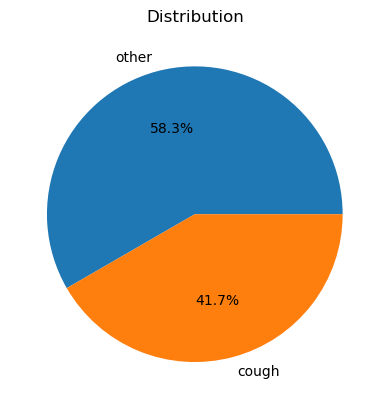

In [21]:
# Converting the Audiodata dictionary into the pandas dataframe

# Train data

df_train = pd.DataFrame.from_dict(Audiodata_train)

print("Train Data \n")
print("-------------------")
print(df_train.head())
print()

mfcc_values = np.array(df_train['mfcc'].tolist())
mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

sc_values = np.array(df_train['sc'].tolist())
sc_values = sc_values.reshape(sc_values.shape[0], -1)

percentile_values = df_train.iloc[:, :4].values

X_train = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)
X_train_per = percentile_values
X_train_per_mfcc =  np.concatenate((percentile_values, mfcc_values), axis=1)
X_train_mfcc_sc = np.concatenate((mfcc_values, sc_values), axis=1)

label_encoder = LabelEncoder()
y_train = df_train.iloc[:, -1]
y_train = 1 - label_encoder.fit_transform(y_train)

label_counts = df_train['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title("Distribution")
plt.show()

In [22]:
kf = KFold(n_splits=5, shuffle=False)

# Extraction and Classification Performance of the Model on Test Data

## Time Domain Sound Extraction Functions

In [23]:
# Cough Detection Algorithm

def detect_coughs_time_domain(data):
    
    max_value = np.max(data)
    mean_value = np.mean(data)
    std = np.std(data)

    # Threshold 
    percentile_threshold = 90
    threshold = np.percentile(data, percentile_threshold)

    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 0.3)
    cough_indices = list(cough_indices)

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 5000, peak + 5000) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1


    # Applying the threshold
    cough_indices_copy = cough_indices.copy()
    for index in cough_indices_copy:

        amplitude = data[index]

        if (amplitude < threshold):
            cough_indices.remove(index)


    # Finding the timestamps of the coughs
    predicted_timestamps = []
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))


    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        matches = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))

        if len(matches) != 0:
            for i in range(len(matches)):
                index = predicted_timestamps.index(matches[i])
                predicted_timestamps.remove(matches[i])
                cough_indices.remove(cough_indices[index])

    return cough_indices, predicted_timestamps

## Frequency Domain Sound Extraction Functions

In [24]:
# Summation of the frequency bins in a spectogram

def get_frequency_sums(mel_spectrogram_db):
    
    sums = []

    for bin in mel_spectrogram_db:
        sums.append(np.sum(bin))

    sums = np.array(sums)

    return sums

In [25]:
def detect_coughs_freq_domain(data, percentile_threshold = 90):
    
    duration = len(data) / sample_rate
    
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate).T
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)    
    
    frequency_sums = get_frequency_sums(mel_spectrogram_db)
    
    # Threshold 
    threshold = np.percentile(frequency_sums, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(frequency_sums, prominence = 0.3)
    cough_indices = list(cough_indices)
    
    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 50, peak + 50) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (frequency_sums[index] > frequency_sums[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1

    # Applying the threshold
    cough_indices_copy = list(cough_indices)
    for index in cough_indices_copy: 
        amplitude = frequency_sums[index]
        if amplitude < threshold:
            cough_indices.remove(index)
    
    # Finding the timestamps of the coughs
    predicted_timestamps = []
    
    total_samples = len(data)
    data_length = len(frequency_sums)
    
    # Finding the timestamps of the coughs
    for index in cough_indices:
        
        actual_index = total_samples * index / data_length
        actual_timestamp = round(actual_index / sample_rate, 6)
        
        predicted_timestamps.append(actual_timestamp)
    
    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        match = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))
        if len(match) != 0:
            index = predicted_timestamps.index(match[0])
            predicted_timestamps.remove(match[0])
            cough_indices.remove(cough_indices[index])

    
    return cough_indices, predicted_timestamps

In [119]:
def detect_coughs(preprocessed_data, model, extracted_test_data):

    # Extraction of high frequency signals (cough/other) from the audio
    audio_peak_extractions = []
    
    # Time-based and frequency-based extractions
    cough_indices_time, predicted_timestamps_time = detect_coughs_time_domain(preprocessed_data)
    cough_indices_freq, predicted_timestamps_freq = detect_coughs_freq_domain(preprocessed_data)

    predicted_timestamps = []

    # Getting predicted timestamps by comparing time-based and frequency-based extractions

    for timestamp in predicted_timestamps_freq:

        if any(timestamp - 0.15 < element < timestamp + 0.15 for element in predicted_timestamps_time):

            predicted_timestamps.append(timestamp)
        
    # Getting the extracted data
    for timestamp in predicted_timestamps:

        start = int((timestamp - timestamp_range_min) * sample_rate)
        finish = int((timestamp + timestamp_range_max) * sample_rate)

        if start < 0:
            start = 0

        if finish > len(preprocessed_data):
            finish = len(preprocessed_data) - 1

        extracted_data = preprocessed_data[start:finish]
    
        # Add padding or truncate if necessary
        if len(extracted_data) < data_shape:
            
            padding_size = data_shape - len(extracted_data)
            left_padding = padding_size // 2
            right_padding = padding_size - left_padding

            extracted_data = np.pad(extracted_data, (left_padding, right_padding), mode='constant', constant_values=0)

        elif len(extracted_data) > data_shape:
            extracted_data = extracted_data[:data_shape]

        audio_peak_extractions.append((extracted_data, timestamp))
        extracted_test_data['data'].append(extracted_data)
    
    # Getting features of the extracted audio data
    Audiodata_new = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc':[]}
    
    for peak, timestamp in audio_peak_extractions:

        # Percentile Calculation
        per_25, per_50, per_75, per_90 = find_percentile_points(peak)


        # MFCC Feature extraction
        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(peak)

        # Comprehensive MFCCs
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

        # Find spectral centroids
        sc = librosa.feature.spectral_centroid(y=peak, sr=sample_rate)

        Audiodata_new['percentile_25'].append(per_25)
        Audiodata_new['percentile_50'].append(per_50)
        Audiodata_new['percentile_75'].append(per_75)
        Audiodata_new['percentile_90'].append(per_90)
        Audiodata_new['mfcc'].append(comprehensive_mfccs)
        Audiodata_new['sc'].append(sc)


    df_new = pd.DataFrame.from_dict(Audiodata_new)
    
    try:
    # Both MFCCs and Percentiles
        mfcc_values = np.array(df_new['mfcc'].tolist())
        mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

        sc_values = np.array(df_new['sc'].tolist())
        sc_values = sc_values.reshape(sc_values.shape[0], -1)

        percentile_values = df_new.iloc[:, :4].values

        new_data = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)    
        prediction = model.predict(new_data)

        final_prediction = []

        for i in range(len(predicted_timestamps)):
            if (prediction[i] == 1):
                final_prediction.append(predicted_timestamps[i])

        #print(f"P Timestamps: {predicted_timestamps}")
        return final_prediction
    
    except: 
        return []

# Prediction and Performance

In [27]:
# Test data loading

audio_data_test = X_test_init.copy()

audio_data_test

,audio,timestamps,label
12,"[-0.0014953613, -0.0015258789, -0.0014953613, ...","[1.973696, 4.708879, 14.192288, 27.790743]",cough
44,"[0.05895996, 0.06600952, 0.06201172, 0.0666198...","[4.8878, 23.045805, 44.501043, 45.83619, 47.41...",cough
23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.865809, 2.365563, 13.204682, 13.671662, 22....",cough
9,"[0.012420654, 0.025421143, 0.030853271, 0.0290...","[2.233332, 3.304087, 11.01195, 23.563642]",cough
13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.793256, 4.184563, 9.78828, 10.954947, 17.44...",cough
16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.100679, 3.424441, 5.165727]",cough
6,"[-0.0004272461, -0.00048828125, -0.00061035156...","[4.007188, 6.963311, 12.021565, 23.231565, 27....",cough
4,"[0.006500244, 0.0027160645, -0.0010986328, -0....","[3.297234, 11.052698, 18.761723]",cough
33,"[-0.003540039, -0.0073242188, -0.008422852, -0...",[39.404319],cough
40,"[0.001159668, 0.002380371, 0.0030212402, 0.003...","[1.116596, 44.99989]",cough


In [28]:
def model_selection(models_list, model_hyperparameters):
    
    results = []
    model_keys = list(model_hyperparameters.keys())
    
    for i in range(len(models_list)):
        
        key = model_keys[i]
        params = model_hyperparameters[key]
        
        classifier = GridSearchCV(models_list[i], params, cv=5, scoring='f1')
        classifier.fit(X_train, y_train)
        
        results.append({
            'model used': models_list[i],
            'highest score': classifier.best_score_,
            'best hyperparameters': classifier.best_params_,
            
        })

    
    result_dataframe = pd.DataFrame(results, columns = ['model used', 'highest score', 'best hyperparameters'])    
    return result_dataframe

In [29]:
"""
Models: 

0                                           SVC(C=0.5)
1    KNeighborsClassifier(n_neighbors=161, weights=...
2    (DecisionTreeClassifier(max_features='sqrt', r...
3      GaussianNB(var_smoothing=5.336699231206313e-07)

"""
models_list = [SVC(), KNeighborsClassifier(), RandomForestClassifier(random_state=0), GaussianNB()]


model_hyperparameters = {

    'svc_hyperparameters': {
        
        'C': [0.5, 1, 10, 100],
        'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
        
    },
    
    'KNN_hyperparameters': {
        
        'n_neighbors': list(range(3, int(len(X_train) * 0.65),2)),
        'weights': ['uniform', 'distance']

    },
    
    'random_forest_hyperparameters': {
        
        'n_estimators': [10, 20, 50, 100]
    },
    
    'naive_bayes_hyperparameters': {
    
        'var_smoothing': np.logspace(0,-9, num=100)
    },
        
}

result_df = model_selection(models_list, model_hyperparameters)

for model_info in result_df.values:
    
    model = model_info[0]
    best_params = model_info[2]
    
    model.set_params(**best_params)
    model.fit(X_train, y_train)


model_list = result_df['model used']

In [118]:
predicted_and_real_timestamps = {'real': [], 'predicted': []}
extracted_test_data = {'data': [], 'label': []}

for row in audio_data_test.values:

    data = row[0]
    timestamps = row[1]

    data = preprocess_data(data)

    #print(f"R Timestamps: {timestamps}")
    detected_cough_timestamps = detect_coughs(data, model, extracted_test_data)
    #print()

    predicted_and_real_timestamps['real'].append(timestamps)
    predicted_and_real_timestamps['predicted'].append(detected_cough_timestamps)

TypeError: detect_coughs() takes 2 positional arguments but 3 were given

In [120]:
# KNN Prediction

model = models_list[1]

tp = 0
fp = 0
fn = 0

print(model)
print("-----------------------------")


    
pr_df = pd.DataFrame.from_dict(predicted_and_real_timestamps)

for row in pr_df.values:

    real_timestamps = row[0]
    predicted_timestamps = row[1]

    real_timestamps.sort()
    predicted_timestamps.sort()

    #plt.figure(figsize=(6, 3))

    for real, pred in zip(real_timestamps, predicted_timestamps):
        if any(real - 0.15 < p < real + 0.15 for p in predicted_timestamps):
            tp += 1
        else:
            fn += 1

        if not any(pred - 0.15 < r < pred + 0.15 for r in real_timestamps):
            fp += 1

print(tp)
print(fn)
print(fp)

recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * recall * precision / (recall + precision)

print(f"The F1 score of {model}: {round(f1,3)}")
print()

KNeighborsClassifier(n_neighbors=3, weights='distance')
-----------------------------
0
0
0


ZeroDivisionError: division by zero

In [32]:
for model in model_list: 
        
    tp = 0
    fp = 0
    fn = 0

    print(model)
    print("-----------------------------")
    
    predicted_and_real_timestamps = {'real': [], 'predicted': []}

    for row in audio_data_test.values:

        data = row[0]
        timestamps = row[1]

        data = preprocess_data(data)

        #print(f"R Timestamps: {timestamps}")
        detected_cough_timestamps = detect_coughs(data, model)
        #print()

        predicted_and_real_timestamps['real'].append(timestamps)
        predicted_and_real_timestamps['predicted'].append(detected_cough_timestamps)

    """2
    plt.subplot(1, 2, 1)
    plt.title("Real")
    plt.plot(time, data, label='Signal')
    plt.scatter(timestamps, np.zeros_like(timestamps), marker='o', color='red', label='Real Timestamps', s=10, zorder=5)

    # Plot predicted timestamps
    plt.subplot(1, 2, 2)
    plt.title("Prediction")
    plt.plot(time, data, label='Signal')
    plt.scatter(detected_cough_timestamps, np.zeros_like(detected_cough_timestamps), marker='o', color='red', label='Predicted Timestamps', s=10, zorder=5)

    plt.tight_layout()
    plt.show()
    print()
    """

    pr_df = pd.DataFrame.from_dict(predicted_and_real_timestamps)

    for row in pr_df.values:

        real_timestamps = row[0]
        predicted_timestamps = row[1]

        real_timestamps.sort()
        predicted_timestamps.sort()
        
        #plt.figure(figsize=(6, 3))

        for real, pred in zip(real_timestamps, predicted_timestamps):
            if any(real - 0.15 < p < real + 0.15 for p in predicted_timestamps):
                tp += 1
            else:
                fn += 1

            if not any(pred - 0.15 < r < pred + 0.15 for r in real_timestamps):
                fp += 1

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * recall * precision / (recall + precision)

    print(f"The F1 score of {model}: {round(f1,3)}")
    print()

SVC(C=100)
-----------------------------
The F1 score of SVC(C=100): 0.75

KNeighborsClassifier(n_neighbors=3, weights='distance')
-----------------------------
The F1 score of KNeighborsClassifier(n_neighbors=3, weights='distance'): 0.723

RandomForestClassifier(random_state=0)
-----------------------------
The F1 score of RandomForestClassifier(random_state=0): 0.743

GaussianNB(var_smoothing=8.111308307896856e-09)
-----------------------------
The F1 score of GaussianNB(var_smoothing=8.111308307896856e-09): 0.75



# CNN

In [99]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

In [100]:
def get_melspectrogram(data):
    
    melspec = librosa.feature.melspectrogram(y = data,
                                                  sr = sample_rate, 
                                                  n_fft = 512, 
                                                  hop_length = 256, 
                                                  n_mels = 40).T

    melspec = librosa.power_to_db(melspec)
    
    return melspec

In [101]:
df_train_extracted

,data,label
276,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough
88,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",other
289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough
120,"[0.04166666666666667, 0.04166666666666667, 0.0...",other
269,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cough
...,...,...
331,"[0.03571427408058282, 0.035714299315624434, 0....",other
332,"[-1.1633702889923825e-08, 1.3601338721969114e-...",other
333,"[-1.1633702889923825e-08, 1.3601338721969114e-...",other
334,"[-1.1633702889923825e-08, 1.3601338721969114e-...",other


In [102]:
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2):
        
    n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [105]:
# Melspectrograms
mel_dict = {'data': [], 'label': []}

for row in df_train_extracted.values:
    
    data = row[0]
    label = row[1]
    
    melspec = get_melspectrogram(data)
    melspec = torch.tensor(melspec)

    mel_dict['data'].append(melspec)
    mel_dict['label'].append(label)   
    
    augmented_spec = spectro_augment(spec)  
    mel_dict['data'].append(augmented_spec)
    mel_dict['label'].append(label)  


In [106]:
class MelSpecDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        spec = self.dataframe.loc[idx, 'data']
        label = self.dataframe.loc[idx, 'label']
        return spec, label

In [117]:
df_mel_spec = pd.DataFrame.from_dict(mel_dict)
train_ds = MelSpecDataset(df_mel_spec)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
